In [1]:
from archetypes import BiAA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

In [3]:
data = pd.read_csv("data/enron_mails_adjacency_matrix.csv", index_col=0)
data[data != 0] = 1

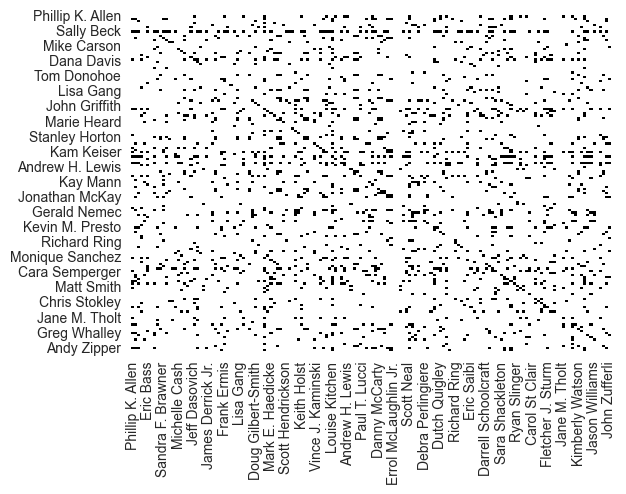

In [4]:
cmap = ListedColormap(['w', 'k'])

sns.heatmap(data, cmap=cmap, vmin=0, vmax=1, cbar=False)
plt.rcParams.update({'font.size': 8})
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.25, top=0.95)
plt.show()

In [6]:
X = data.to_numpy().astype("f")

In [7]:
model = BiAA(n_archetypes=(6, 6), max_iter=10_000, n_init=5, random_state=123)
_ = model.fit(X)

In [14]:
ind_0 = [i0 for i0, _ in sorted([(i, k.item()) for i, k in enumerate(model.alphas_.argmax(1))], key = lambda j:
j[1])]
ind_1 = [i0 for i0, _ in sorted([(i, k.item()) for i, k in enumerate(model.gammas_.argmax(0))], key = lambda j:
j[1])]

In [16]:
hlines = [0] + [i for i in np.array(np.bincount(model.alphas_.argmax(1))).cumsum()]
vlines = [0] + [i for i in np.array(np.bincount(model.gammas_.argmax(0))).cumsum()]

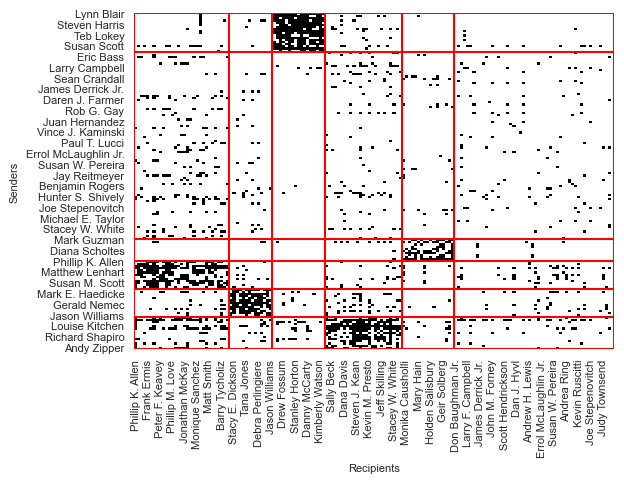

In [17]:
sorted_data = X[ind_0, :][:, ind_1]
sorted_index = data.index[ind_0]
sorted_columns = data.columns[ind_1]

sorted_df = pd.DataFrame(sorted_data, index=sorted_index, columns=sorted_columns)
sns.heatmap(sorted_df, cmap=cmap, vmin=0, vmax=1, cbar=False)
for y in hlines:
    plt.axhline(y=y, c="r")
for x in vlines:
    plt.axvline(x=x, c="r")

plt.rcParams.update({'font.size': 8})
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.25, top=0.95)
plt.ylabel("Senders")
plt.xlabel("Recipients")

plt.show()

In [19]:
employee_info = pd.read_csv("data/enron_employee_information.csv", index_col=0)

In [22]:
ei = employee_info.join(pd.DataFrame(model.gammas_.argmax(0), index=data.index, columns=["Group"]))

In [23]:
A = model.alphas_

dfA = pd.DataFrame({"Argmax": A.argmax(1), "Max": A.max(1)}, index=data.index)
dfA = dfA.join(employee_info)
dfA = dfA.sort_values(["Argmax", "Max"], ascending=[True, False])

for k, g in dfA.groupby("Argmax"):
    print(f"Group: {k}")
    print(g.head(5)[["Department", "Title"]])

Group: 0
                Department     Title
Lynn Blair             ETS  Director
Lindy Donoho           ETS  Employee
Kevin Hyatt            ETS  Director
Michelle Lokay         ETS  Director
Kimberly Watson        ETS  Director
Group: 1
                       Department          Title
Don Baughman Jr.   ENA East Power    Mgr Trading
Robert Benson      ENA East Power    Dir Trading
James Derrick Jr.           Enron  VP & Gen Cnsl
Mary Fischer                  NaN       Employee
Rob G. Gay                    NaN       Employee
Group: 2
                              Department        Title
Kate Symes      ENA West Power Real Time     Employee
Cara Semperger            ENA West Power   Specialist
Geir Solberg    ENA West Power Real Time      Analyst
Mark Guzman     ENA West Power Real Time   Specialist
Diana Scholtes            ENA West Power  Dir Trading
Group: 3
                        Department        Title
Mike Grigsby          ENA Gas West   VP Trading
Kam Keiser       Energy Oper

In [24]:
D = model.gammas_

dfD = pd.DataFrame({"Argmax": D.argmax(0), "Max": D.max(0)}, index=data.index)
dfD = dfD.join(employee_info)
dfD = dfD.sort_values(["Argmax", "Max"], ascending=[True, False])

for k, g in dfD.groupby("Argmax"):
    print(f"Group: {k}")
    print(g.head(5)[["Department", "Title"]])

Group: 0
                   Department        Title
Mike Grigsby     ENA Gas West   VP Trading
Matthew Lenhart  ENA Gas West      Analyst
Jay Reitmeyer    ENA Gas West    Associate
Frank Ermis      ENA Gas West  Dir Trading
Keith Holst      ENA Gas West  Dir Trading
Group: 1
                  Department             Title
Stacy E. Dickson   ENA Legal              Cnsl
Debra Perlingiere  ENA Legal  Specialist Legal
Gerald Nemec       ENA Legal           Manager
Stephanie Panus    ENA Legal  Specialist Legal
Sara Shackleton    ENA Legal     Gen Cnsl Asst
Group: 2
                Department     Title
Lindy Donoho           ETS  Employee
Steven Harris          ETS        VP
Michelle Lokay         ETS  Director
Kimberly Watson        ETS  Director
Kevin Hyatt            ETS  Director
Group: 3
                    Department                Title
Louise Kitchen             EWS                  COO
Jeffrey A. Shankman        EWS                  COO
Greg Whalley               EWS      President 

In [25]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

As = A[A.argmax(axis=1) != 2, :]
indexs = data.index[A.argmax(axis=1) != 2]
dfAs = pd.DataFrame({"Argmax": As.argmax(axis=1), "Max": As.max(axis=1)}, index=indexs)
dfAs = dfAs.join(employee_info)
dflabels = dfAs
dfAs = dfAs.sort_values(["Argmax", "Max"], ascending=[True, False])

labels = []
for k, g in dfAs.groupby("Argmax"):
    labels += list(g.head(3).index)

adj_matrix = cosine_similarity(As)
adj_matrix[np.eye(adj_matrix.shape[0], dtype=bool)] = 0

In [30]:
G2 = nx.from_numpy_matrix(adj_matrix)
pos2 = nx.spring_layout(G2)
node_size = As.max(axis=1)
node_color = As.argmax(axis=1)
edges = G2.edges(data=True)
nodes = G2.nodes()


In [31]:
widths = nx.get_edge_attributes(G2, 'weight')
nodelist = np.array(G2.nodes())

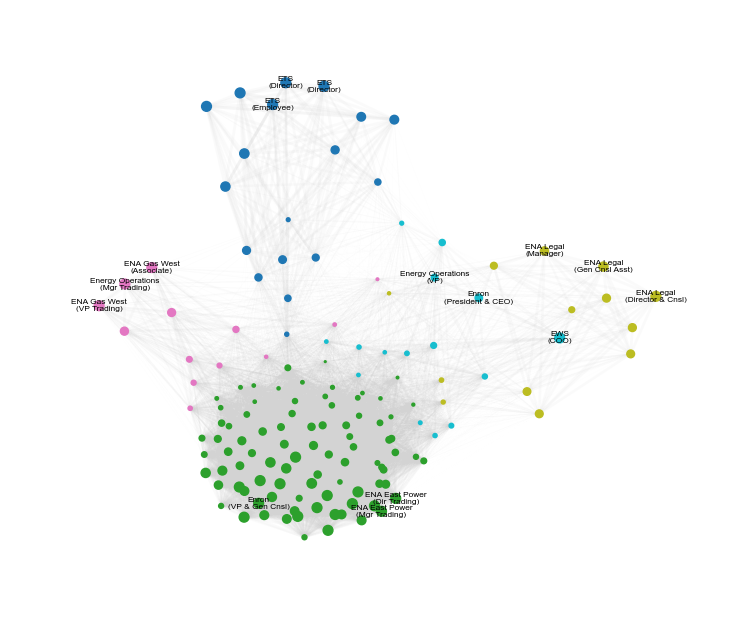

In [32]:
plt.figure(figsize=(7, 5))
nx.draw_networkx_edges(G2, pos2,
                       edgelist = widths.keys(),
                       width=2 * np.array(list(widths.values())) ** 3,
                       edge_color='lightgrey',
                       alpha=0.1)
nx.draw_networkx_nodes(G2, pos=pos2, nodelist=nodelist, node_size=node_size ** 3 * 50, node_color=node_color,
                       cmap="tab10")

index = [True if l in labels else False for l in dflabels.index]

node_label = dflabels.iloc[index, :]
string = lambda x: "{Department}\n({Title})".format(**x)
node_label = node_label.apply(string, 1)
nx.draw_networkx_labels(G2, pos2,
                        font_size=6,
                       labels = dict(zip(nodelist[index], node_label)))

plt.axis('off')
plt.margins(x=0.1, y=0.1)
plt.subplots_adjust(left=-0.05, right=1, bottom=-0.1, top=1.1)

plt.show()